# **Análisis de BigData**

Dataset utilizado: Crimes in Toront

Este conjunto de datos incluye todas las ocurrencias de Indicadores Principales de Crimen (MCI, por sus siglas en inglés) según la fecha de reporte y los delitos relacionados, cubriendo el período desde 2014 hasta enero de 2025.


## Instalación e importe de librerias

In [ ]:
# Instalar PySpark
!pip install pyspark
# Instalar geopandas
!pip install geopandas folium pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

import geopandas as gpd
import folium
from folium.plugins import HeatMap
from pyspark.sql.functions import col

## Inicialización de datos

In [ ]:
# 1. Inicializar Spark
spark = SparkSession.builder.appName("Airbnb_Analisys").getOrCreate()

In [ ]:
# 2. Cargar el archivo directamente
df = spark.read.csv("/content/major-crime-indicators.csv",
                   header=True,
                   inferSchema=True)
# Muestra de dimensiones
print(f"Dimensiones: {df.count()} filas x {len(df.columns)} columnas")

# Filtrar registros con coordenadas válidas
geo_df = df.filter((col("LONG_WGS84").isNotNull()) & (col("LAT_WGS84").isNotNull()))
print(f"Registros con coordenadas válidas: {geo_df.count()}/{df.count()}")

Registros con coordenadas válidas: 413904/420200
Dimensiones: 420200 filas x 29 columnas


# **Análisis Basicos**

## Distribución de crimenes por categoría

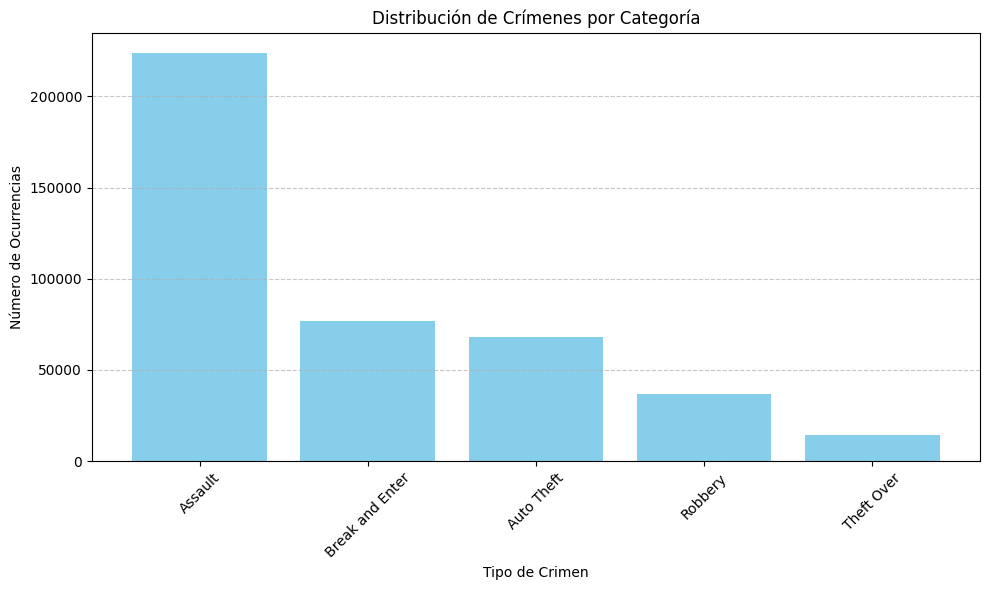

In [ ]:
# 1. Análisis por categoría de crimen
crime_by_category = df.groupBy("MCI_CATEGORY").count().orderBy("count", ascending=False)

# Convertir a Pandas para visualización
crime_pd = crime_by_category.toPandas()

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(crime_pd["MCI_CATEGORY"], crime_pd["count"], color='skyblue')
plt.title("Distribución de Crímenes por Categoría")
plt.xlabel("Tipo de Crimen")
plt.ylabel("Número de Ocurrencias")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribución de Crímenes por Hora del Día

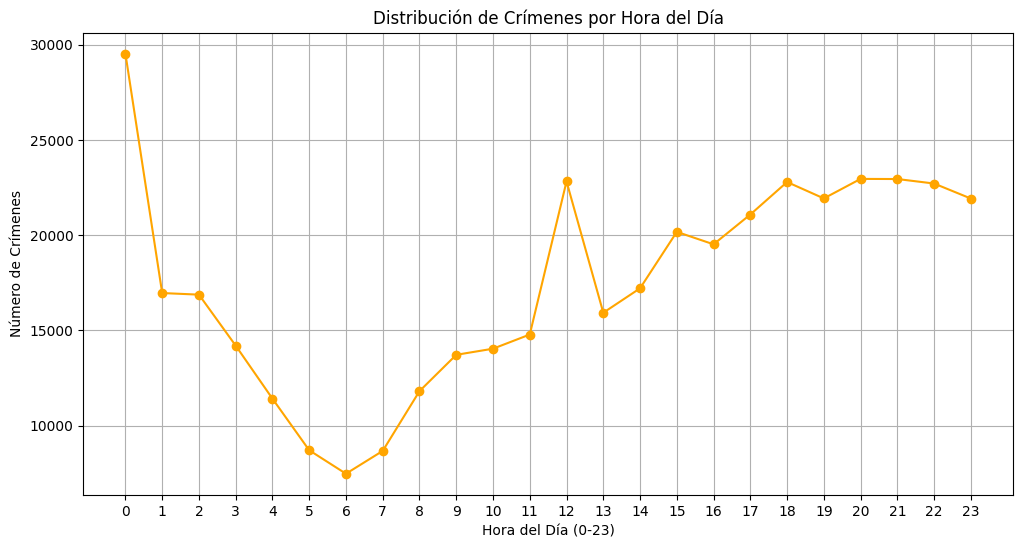

In [ ]:
# 2. Análisis por hora del día (OCC_HOUR)
crime_by_hour = df.groupBy("OCC_HOUR").count().orderBy("OCC_HOUR")

# Convertir a Pandas y visualizar
hour_pd = crime_by_hour.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(hour_pd["OCC_HOUR"], hour_pd["count"], marker='o', color='orange')
plt.title("Distribución de Crímenes por Hora del Día")
plt.xlabel("Hora del Día (0-23)")
plt.ylabel("Número de Crímenes")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## Vecindarios con más registros de crimenes

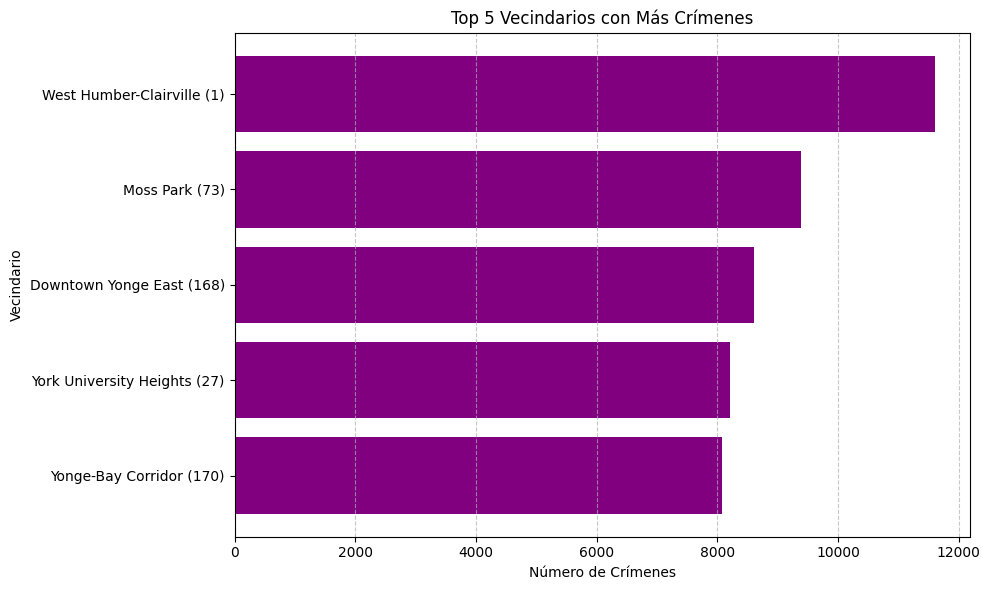

In [ ]:
# 3. Top 5 vecindarios con más crímenes
top_neighborhoods = df.groupBy("NEIGHBOURHOOD_158").count() \
                     .orderBy("count", ascending=False) \
                     .limit(5)

neighborhood_pd = top_neighborhoods.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(neighborhood_pd["NEIGHBOURHOOD_158"], neighborhood_pd["count"], color='purple')
plt.title("Top 5 Vecindarios con Más Crímenes")
plt.xlabel("Número de Crímenes")
plt.ylabel("Vecindario")
plt.gca().invert_yaxis()  # Para mostrar el más alto primero
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribución anual de los crimenes

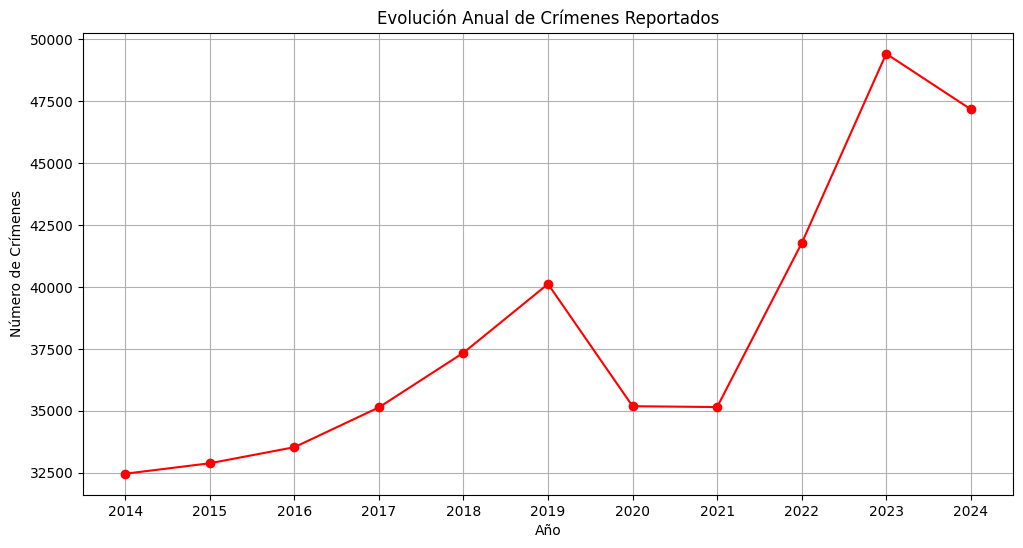

In [ ]:
# 4. Evolución anual de crímenes
crime_by_year = df.groupBy("REPORT_YEAR").count().orderBy("REPORT_YEAR")

year_pd = crime_by_year.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(year_pd["REPORT_YEAR"], year_pd["count"], marker='o', linestyle='-', color='red')
plt.title("Evolución Anual de Crímenes Reportados")
plt.xlabel("Año")
plt.ylabel("Número de Crímenes")
plt.xticks(year_pd["REPORT_YEAR"])
plt.grid(True)
plt.show()

## Estimación de densidad de registro de acontecimientos criminales

In [ ]:
# 5. Estimación de densidad de crimenes en mapa de calor
# Tomar una muestra para el mapa
sample_geo_df = geo_df.sample(fraction=0.1, seed=42) if geo_df.count() > 10000 else geo_df

# Convertir a Pandas para visualización
geo_pd = sample_geo_df.select("LAT_WGS84", "LONG_WGS84", "MCI_CATEGORY").toPandas()

# Crear mapa centrado en Toronto
toronto_coords = [43.70, -79.40]
crime_map = folium.Map(location=toronto_coords, zoom_start=11)

# Añadir capa de calor
heat_data = [[row['LAT_WGS84'], row['LONG_WGS84']] for _, row in geo_pd.iterrows()]
HeatMap(heat_data, radius=10).add_to(crime_map)

# Mostrar mapa
crime_map.save('crime_heatmap.html')
crime_map